## Initial Setup

In [1]:
#!pip install rembg
#!pip install onnxruntime # required for rembg
#!pip install tensorflow-hub

In [2]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from rembg import remove
import io


2025-04-08 20:56:25.904321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Import custom modules
import adversarial_attacks as advattacks
from utils import remove_background, detect_and_crop, crop_to_square, expand_to_square

# Set default display paratmeters for matplotlib
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Set Variables used for the adversarial attack
epsilon = [0.05]  # Epsilon value for perturbation
loss_fn = 0  # 0 = CategoricalCrossentropy

# Set Debug mode
DEBUG = False # Set to True for debugging output


## Load Pre-Trained Model

In [4]:
# Load pretrained MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True)
model.trainable = False # Freeze the model

# Review model architecture
print(f"Model: {model.name}")
print(f"Number of layers: {len(model.layers)}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])}")


Model: mobilenetv2_1.00_224
Number of layers: 156
Trainable parameters: 0
Non-trainable parameters: 3538984


In [5]:
# Load the ImageNet class names
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Load a pre-trained SSD model from TensorFlow Hub for object detection
# used in the detect_and_crop function
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

# Debugging: Check if ImageNet is loaded correctly
if DEBUG == True:
    print("ImageNet loaded successfully.")
    display(decode_predictions)

## Image Pre-Processing Functions

In [6]:
################################################################################
def preprocess_image(image):
  """
  Function to preprocess the image. This function resizes the image to 224x224 
  pixels and normalizes it to the range expected by MobileNetV2. The function 
  also adds a batch dimension to the image
  
  Args:
    image: The input image.
    
  Returns:
    image: The preprocessed image. 
  """
  
  #image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224), method=tf.image.ResizeMethod.AREA)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]

  # Debugging: Check the Image
  if DEBUG == True:
    print("\n======================================")
    print("=== preprocess_image function call ===")
    print("======================================")
    advattacks.debug_image_output(image)
    print("======================================\n")

  return image

In [7]:
################################################################################
def get_imagenet_label(probs):
   """"
   "Function to get the ImageNet label for the given probabilities. The function
   decodes the predictions and returns the top prediction.

   Args:
       probs: The probabilities of the predictions.

   Returns:
       label: The top prediction.
   """

   label = decode_predictions(probs, top=1)[0][0]

   # Debugging: Check the label
   if DEBUG == True:
        print("\n========================================")
        print("=== get_imagenet_label function call ===")
        print("========================================")  
        print("Predicted label type:", type(label)) # Label type
        print("Predicted class name:", label[1]) # Class name
        print("Predicted confidence:", label[2]) # Probability
        print("Predicted class ID:", label[0]) # Class ID
        print("========================================\n")

   return label

In [8]:
################################################################################
def get_image():
    """
    Function to load and preprocess the image. The function reads the image file,
    decodes the image tensor, and applies a custom preprocessing function. The
    function also handles different image formats and ensures that the image is
    compatible with the MobileNetV2 model.

    Args:
        None

    Returns:
        image: The preprocessed image.
    """

    # Set the image path from the local file
    # Uncomment the image path you want to test
    #image_path = 'images/YellowLabradorLooking_new.jpg'
    #image_path = 'images/diego.jpg'
    #image_path = 'images/paco.jpg'
    #image_path = 'images/mountain.png'
    #image_path = 'images/biscuit.jpg'
    #image_path = 'images/bicycle.jpg'
    image_path = 'images/rotary_phone.jpg'
    
    image_raw = tf.io.read_file(image_path) # reads the image file
    image = tf.image.decode_image(image_raw) # decodes the image tensor

    # Remove background and preprocess the image
    #image = remove_background(image)
    # RESULTS- removing background appears to cause overfitting in the model

    # Detect and crop to the primary object in the image
    #image = detect_and_crop(image)
    # RESULTS- this function works well for most images, but not all

    # The optimal image cropping method is dependent on the image content and must be manually adjusted
    # Crop image to square based on shortest side
    image = crop_to_square(image)  # Crop to a square bounding box

    # Pad the image boundaries to make it square based on longest side
    #image = expand_to_square(image)  # Expand to a square with whitespace

    image = preprocess_image(image) # preprocess the image

    # Debugging: Check the image
    if DEBUG == True:
        print("\n===============================")
        print("=== get_image function call ===")
        print("===============================")
        advattacks.debug_image_output(image) # check the image
        # plt.imshow(image[0])
        # plt.axis('off')
        # plt.show()
        print("Image loaded and preprocessed successfully.")
        print("===============================")
    
    return image


## Original Image

In [9]:
# Load and preprocess the image
image = get_image()  # Load your image

# Predict using the pretrained model
image_probs = model.predict(image)

# # Get the numeric index of the predicted class (0–999)
# label = (get_imagenet_label(image_probs))

# label_index = np.argmax(image_probs) # Get the index of the label

# Get the numeric index of the predicted class (0–999)
imagenet_index = tf.argmax(image_probs[0]).numpy()  # retrieve the predicted image index for the attack

# Decode the predictions to get the class label and confidence
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(image_probs, top=1)
top_prediction = decoded_predictions[0][0]  # Get the top prediction

# Extract the label and confidence
label = top_prediction[1]  # Class label
confidence = top_prediction[2]  # Confidence score

# Debugging: Check the image probabilities
if DEBUG == True:
    print("===============================")   
    print("Image probabilities shape:", image_probs.shape)
    print("Image probabilities:", image_probs.flatten()[:10]) # Print the first 10 probabilities
    print("===============================") 

# Output the results
print(f"ImageNet Index: {imagenet_index}")
print(f"Class Label: {label}")
print(f"Confidence: {confidence * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
ImageNet Index: 528
Class Label: dial_telephone
Confidence: 83.35%


### Review the Image

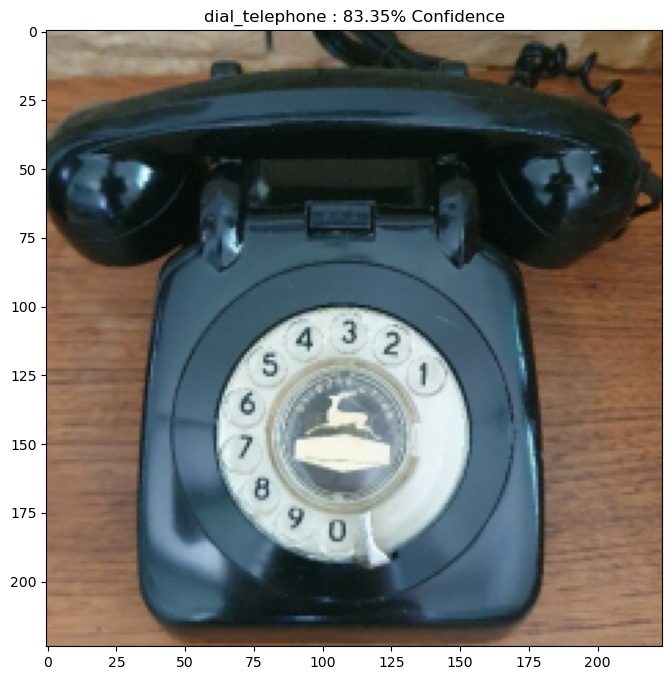

In [10]:
# Display the image
plt.figure() 
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial images

In [11]:
# Debugging: Check the image and label
if DEBUG == True: 
    advattacks.debug_image_output(image)
    advattacks.debug_label_output(get_imagenet_label(image_probs))

In [12]:
# Set various parameters for the attack
# Some of these controls will be integrated into the gradio/streamlit interface

# Set epsilon values (float) for perturbation on all adversarial attacks
# currently value is set at the beginning of this file until integrated into the interface
# epsilons = [0.2]

# Future work: Allow users to select multiple epsilon values
# epsilons = [0.1, 0.2, 0.3, 0.4, 0.5] # Multiple Values
# epsilons = 1e-6 # Used with DeepFool attack

# Set loss function 
loss_function_list = ["CategoricalCrossentropy", 
                      "SparseCategoricalCrossentropy",
                      "BinaryCrossentropy",
                      "MeanSquaredError",
                      "CosineSimilarity"]

# Select the loss function to use
# Currently only CategoricalCrossentropy is implemented

if loss_fn != 0:
    print("Loss function not implemented yet.")
    print("Using CategoricalCrossentropy as default.")
    loss_fn = 0

loss_function = loss_function_list[loss_fn]

# Create an empty label
new_label = ""

if loss_function == "CategoricalCrossentropy":
    loss_object = tf.keras.losses.CategoricalCrossentropy() # Categorical crossentropy loss function    
    new_label = tf.one_hot(imagenet_index, image_probs.shape[-1]) # One-hot encoding of the label
    new_label = tf.reshape(new_label, (1, image_probs.shape[-1])) # Reshape the label to match the input shape of the model
 
elif loss_function == "SparseCategoricalCrossentropy":
    # loss_object = tf.keras.losses.SparseCategoricalCrossentropy() # Sparse categorical crossentropy loss function
    # new_label = (label[-1],)
    print("Sparse categorical crossentropy loss function is not implemented yet.")

# Future work:    
elif loss_function == "BinaryCrossentropy":
    #loss_object = tf.keras.losses.BinaryCrossentropy() # Binary crossentropy loss function
    print("Binary crossentropy loss function is not implemented yet.")


# Future work:    
elif loss_function == "MeanSquaredError":
    #loss_object = tf.keras.losses.MeanSquaredError() # Mean squared error loss function
    print("Mean squared error loss function is not implemented yet.")

# Future work:    
elif loss_function == "CosineSimilarity":
    #loss_object = tf.keras.losses.CosineSimilarity() # Cosine similarity loss function
    print("Cosine similarity loss function is not implemented yet.")
    
# Debugging: Check the loss function and label
if DEBUG == True:
    print("\n=====================================")
    print("=== Loss function and label check ===")
    print("=====================================")
    print("Loss function:", loss_function) # Print the loss function
    print("Loss object:", loss_object) # Print the loss object
    print("\nOrignal label:")
    advattacks.debug_label_output(get_imagenet_label(image_probs)) # Print the label output
    print("Label index:", imagenet_index) # Print the label index
    print("\nNew Label:")
    advattacks.debug_label_output(new_label) # Print the new label output
    

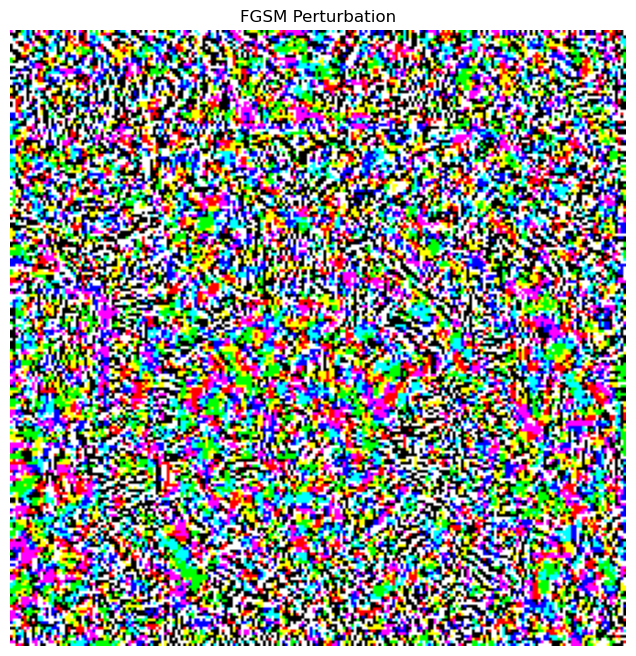

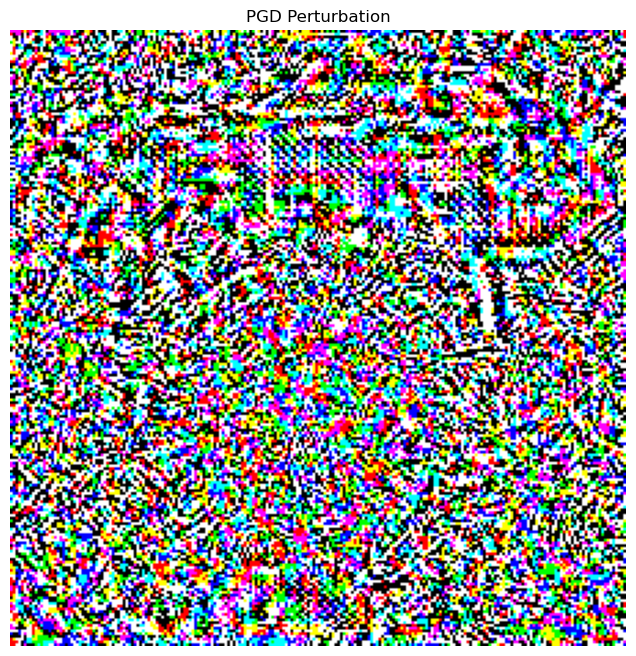

Iteration: 0, Loss: 118826.8515625
Iteration: 100, Loss: 53772.6015625
Iteration: 200, Loss: 42027.484375
Iteration: 300, Loss: 38405.32421875
Iteration: 400, Loss: 36772.71484375
Iteration: 500, Loss: 35878.09765625
Iteration: 600, Loss: 35326.75390625
Iteration: 700, Loss: 34959.1015625
Iteration: 800, Loss: 34699.83203125
Iteration: 900, Loss: 34509.1015625


In [13]:
# Generate adversarial images
fgsm_image, perturbations = advattacks.FGSM(image, new_label, model, loss_object, epsilon)
pgd_image = advattacks.PGD(image, new_label, model, loss_object)
cw_image = advattacks.CW(image, new_label, model)

# Future work:
# jsma_image = advattacks.JSMA(image, new_label, model)
# deepfool_image = advattacks.DeepFool(image, 1000, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


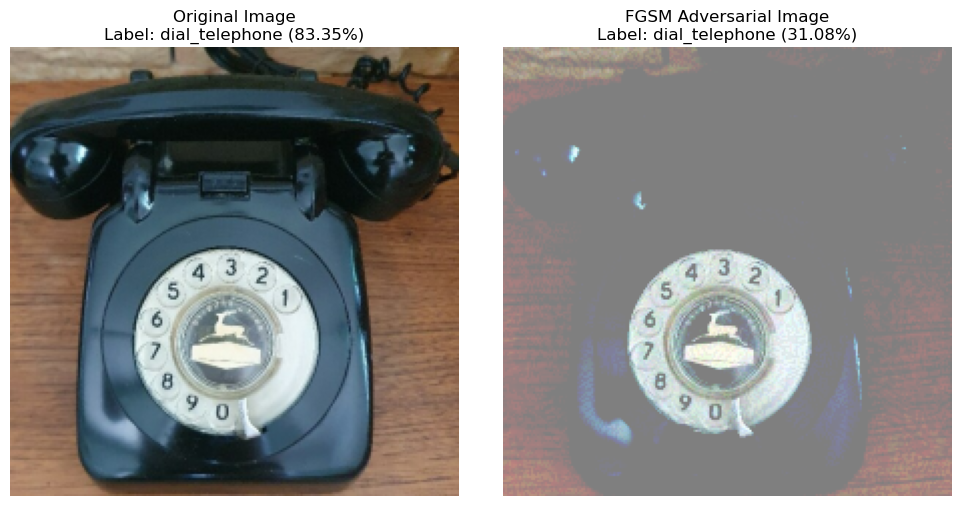

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


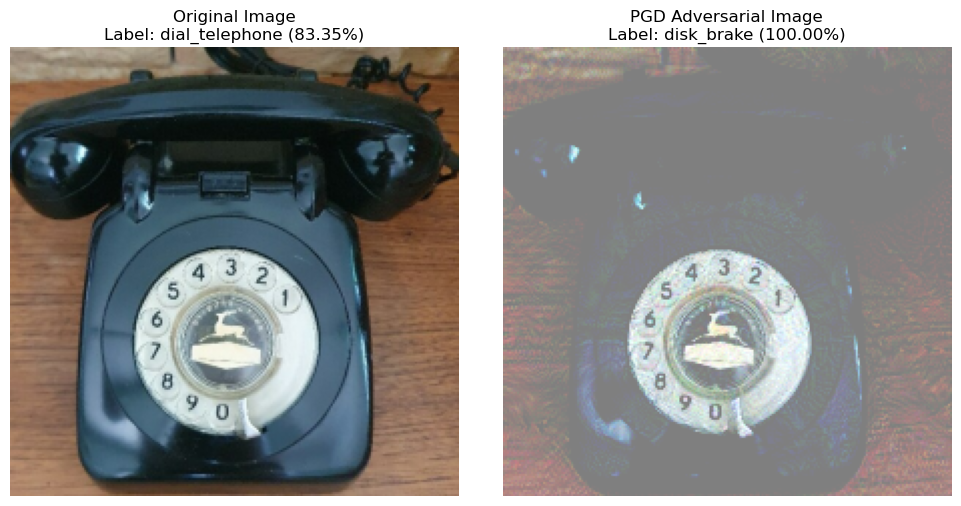

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


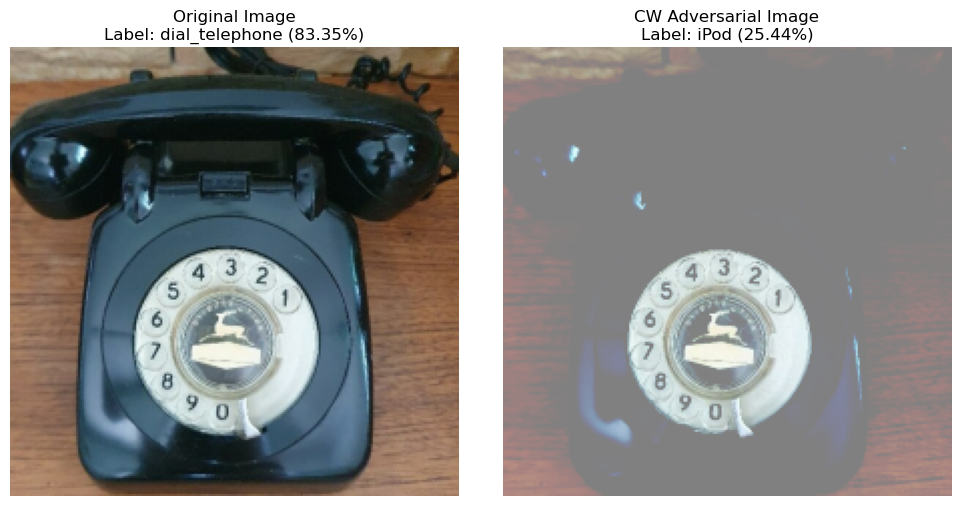

In [14]:
# Visualize the adverarial examples
advattacks.visualize_adversarial_examples(image, fgsm_image, decode_predictions, model, "FGSM")
advattacks.visualize_adversarial_examples(image, pgd_image, decode_predictions, model, "PGD")
advattacks.visualize_adversarial_examples(image, cw_image, decode_predictions, model, "CW")

# Future work:
# advattacks.visualize_adversarial_examples(image, jsma_image, decode_predictions, model, "JSMA")
# advattacks.visualize_adversarial_examples(image, deepfool_image, decode_predictions, model, "DeepFool")


In [15]:
# Future work: Save the adversarial images

# Save the original image
# advattacks.save_adversarial_images(image, image, label, 'output/original')

# Save the adversarial images
# advattacks.save_adversarial_images(image, fgsm_image, label, 'output/fgsm')
# advattacks.save_adversarial_images(image, pgd_image, label, 'output/pgd')
# advattacks.save_adversarial_images(image, cw1_image, label, 'output/cw1')
# advattacks.save_adversarial_images(image, cw2_image, label, 'output/cw2')

# Future work:
# advattacks.save_adversarial_images(image, jsma_image, label, 'output/jsma')
# advattacks.save_adversarial_images(image, deepfool_image, label, 'output/deepfool')
    

## Collect Statistics

In [16]:
def display_images(image, description):
    """
    Display an image with a given description using Matplotlib.
    This function is useful for visualizing the adversarial images generated
    by various attack methods.

    Args:
        image: The image to be displayed.
        description (str): A description of the image.

    Returns:
        None
    """
    
    _, label, confidence = get_imagenet_label(model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    #plt.title('{} \n {} | {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.title('{} \n {}'.format(description, label))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


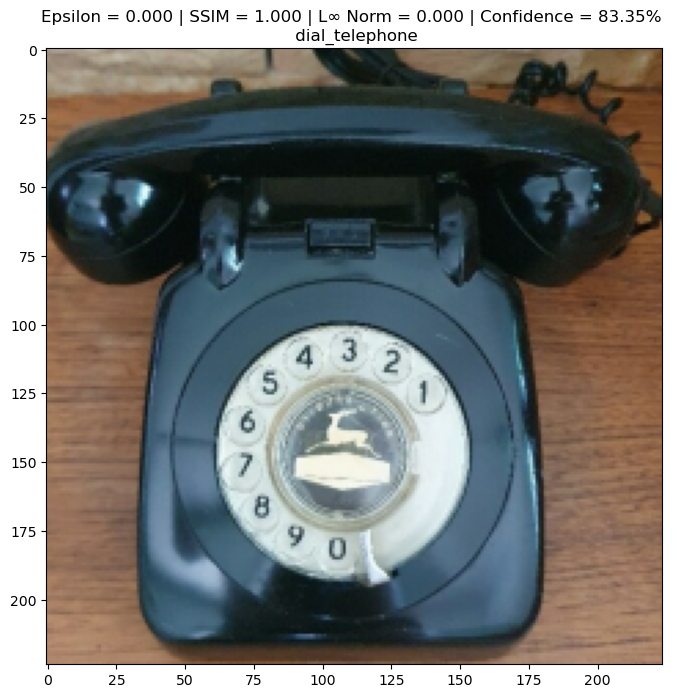

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


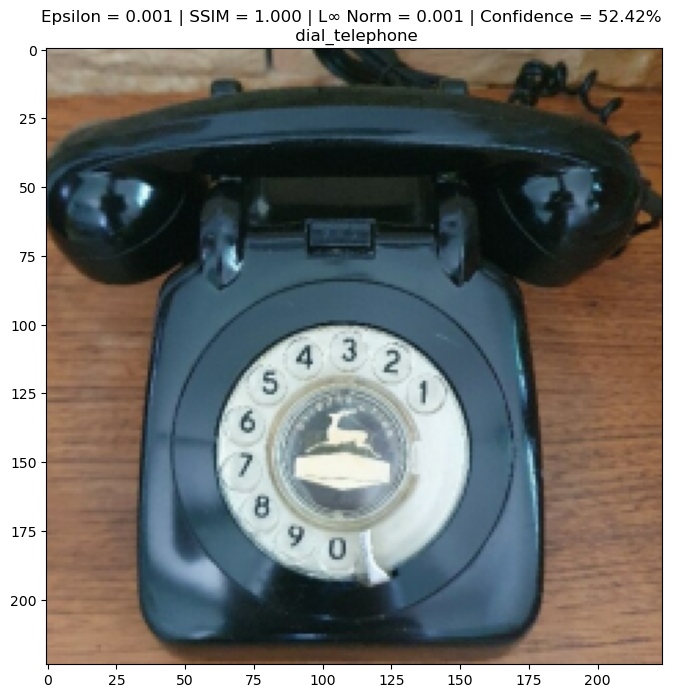

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


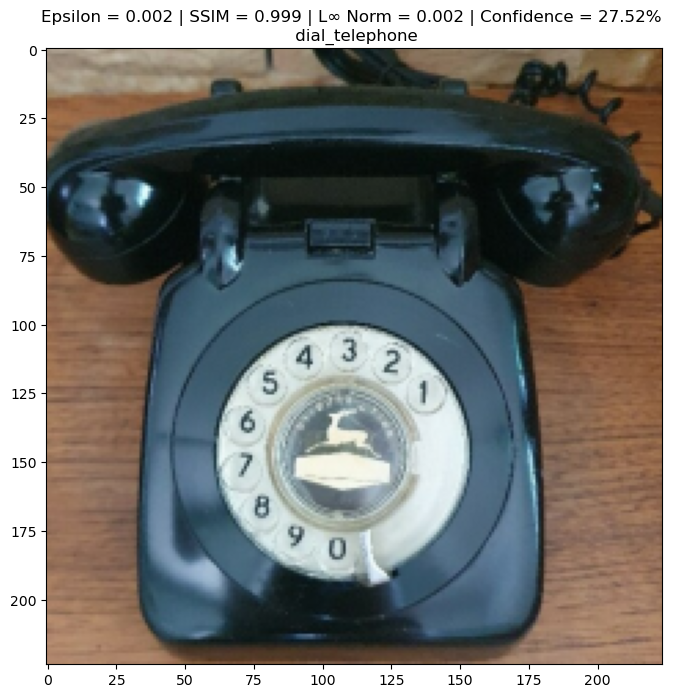

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


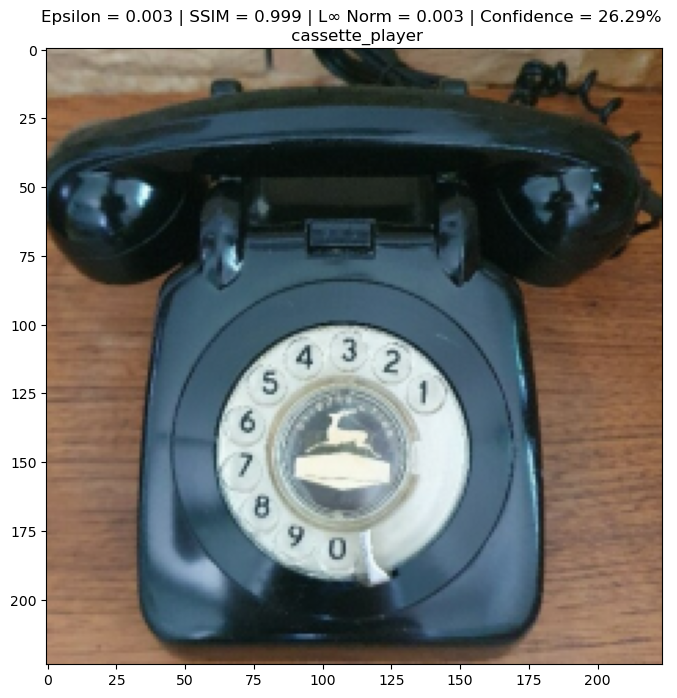

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


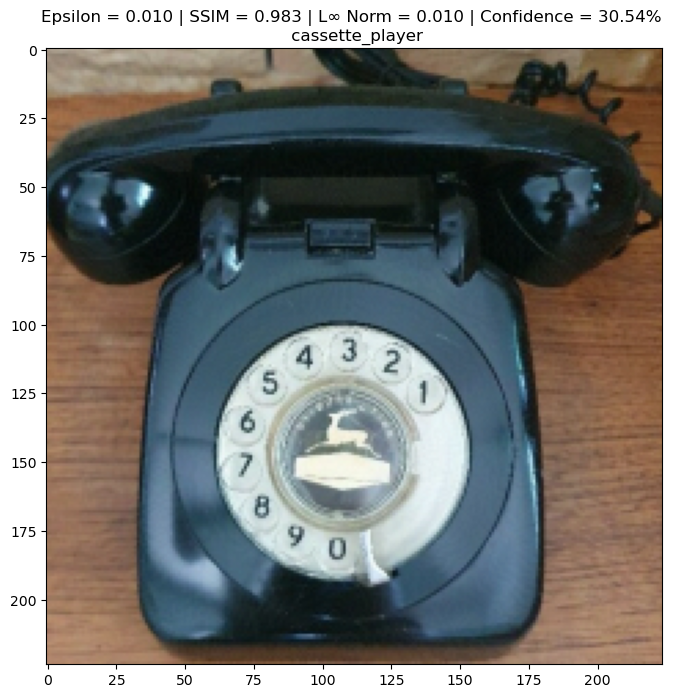

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


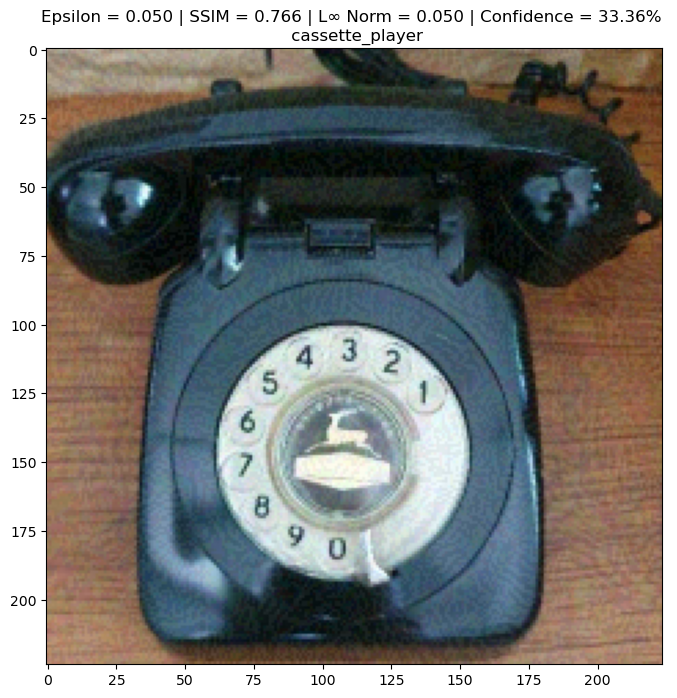

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


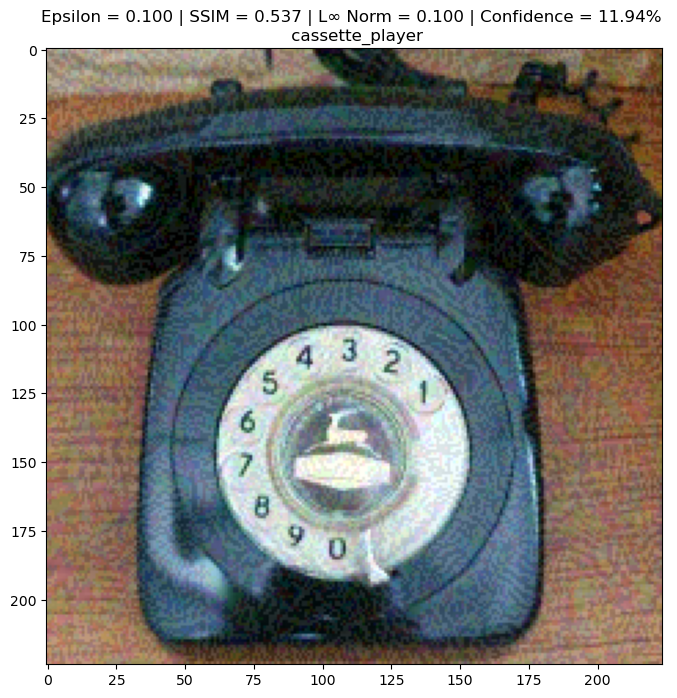

   Epsilon      SSIM  L∞ Norm  Confidence   Classification
0    0.000  1.000000    0.000   83.349633   dial_telephone
1    0.001  0.999945    0.001   52.423298   dial_telephone
2    0.002  0.999463    0.002   27.522847   dial_telephone
3    0.003  0.998557    0.003   26.289475  cassette_player
4    0.010  0.983286    0.010   30.535936  cassette_player
5    0.050  0.765912    0.050   33.360636  cassette_player
6    0.100  0.536990    0.100   11.936045  cassette_player


In [ ]:
original_image = image[0]  # Original image tensor for SSIM calculation

# Define epsilon values
epsilons = [0, 0.001, 0.002, 0.003, 0.01, 0.05, 0.1]

# Initialize a list to store the results
results = []

# Loop through each epsilon value
for i, eps in enumerate(epsilons):
    # Generate adversarial image
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    # Compute SSIM between the original and adversarial images
    ssim_value = tf.image.ssim(original_image, adv_x[0], max_val=1.0)
    ssim_mean = tf.reduce_mean(ssim_value).numpy()  # Average SSIM value

    # Compute L∞ Norm (maximum absolute perturbation)
    linf_norm = tf.reduce_max(tf.abs(original_image - adv_x[0])).numpy()

    # Get the classification label and confidence
    probs = model.predict(adv_x)
    _, label, confidence = get_imagenet_label(probs)

    # Append the results to the list
    results.append({
        "Epsilon": eps,
        "SSIM": ssim_mean,
        "L∞ Norm": linf_norm,
        "Confidence": confidence * 100,  # Convert to percentage
        "Classification": label
    })

    # Add SSIM and L∞ Norm to the description
    description = f"Epsilon = {eps:.3f} | SSIM = {ssim_mean:.3f} | L∞ Norm = {linf_norm:.3f} | Confidence = {confidence * 100:.2f}%"

    # Display the adversarial image with the description
    display_images(adv_x, description)

# Convert the results to a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file for further analysis
# df_results.to_csv("adversarial_results_with_linf.csv", index=False)


# Print the DataFrame to verify
print(df_results)

## Analyze the results

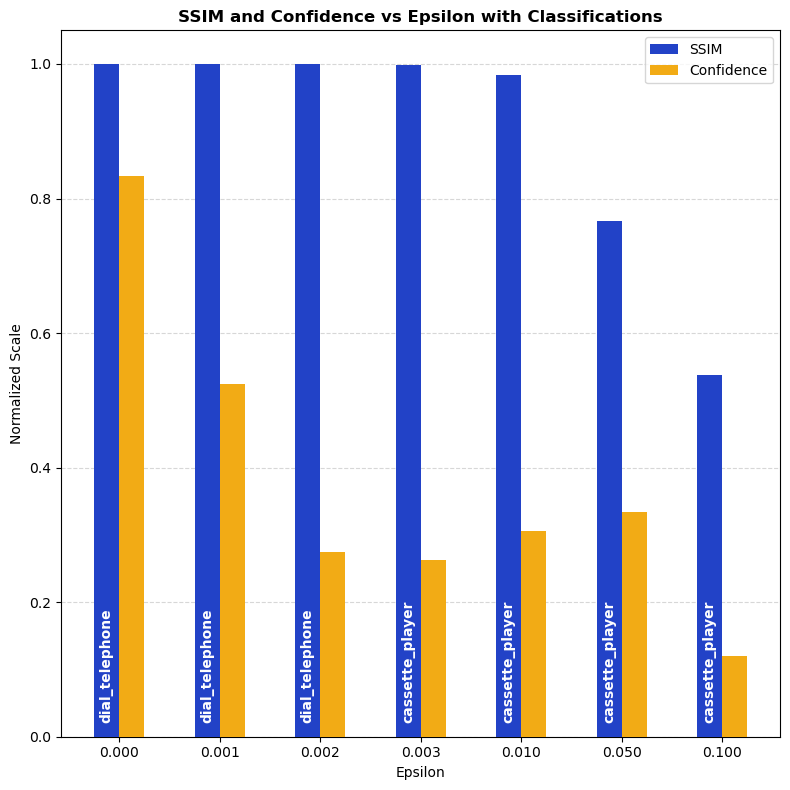

In [18]:
# Extract data from the DataFrame
epsilons = df_results['Epsilon']
ssim_values = df_results['SSIM']
linf_norms = df_results['L∞ Norm']
confidence_values = df_results['Confidence']
classifications = df_results['Classification']  # Extract classification labels

# Define the x-axis positions for the groups
x = np.arange(len(epsilons))  # Positions for the categories
width = 0.25  # Width of the bars

# Create the bar plots
plt.bar(x - width/2, ssim_values, width, label='SSIM', color='#2242c7', zorder=3)  # SSIM values
plt.bar(x + width/2, (confidence_values / 100), width, label='Confidence', color='#f2ab15', zorder=3)  # Confidence values

for i in range(len(epsilons)):
# Place the classification text inside the SSIM bar
    plt.text(
        x[i] - width/2,  # x position
        0.02,  # y position (just above the x-axis, adjust as needed)
        classifications[i],  # text
        ha='center',  # horizontal alignment
        va='bottom',  # vertical alignment
        fontweight='bold',  # make text bold
        fontsize=10,  # font size
        color='white',  # text color
        rotation=90  # rotate text vertically
    )
    
    # Labelling both bars created a cluttered plot, so we only label the SSIM bar
    # # Place the classification text inside the Confidence bar
    # plt.text(
    #     x[i] + width/2,  # x position
    #     (confidence_values[i] / 100) + 0.02,  # y position
    #     classifications[i],  # text
    #     ha='center',  # horizontal alignment
    #     va='bottom',  # vertical alignment
    #     fontsize=10,  # font size
    #     fontweight='bold',  # make text bold
    #     color='black',  # text color for better contrast
    #     rotation=90  # rotate text vertically
    # )

# Add labels, title, and legend
plt.xlabel(('Epsilon'), size=10)
plt.ylabel('Normalized Scale')
plt.title(('SSIM and Confidence vs Epsilon with Classifications'), fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)  # Add grid lines for better readability
plt.xticks(x, [f"{eps:.3f}" for eps in epsilons])  # Format epsilon values on the x-axis
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## User Interface

### This interface is a work in progress to be completed at a later date

In [19]:
# # Import necessary libraries
# import gradio as gr
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# # Define the process_image function that uses actual model predictions
# def process_image(image, epsilon):
#     if image is None:
#         return None, "", 0, "", 0
    
#     try:
#         # Preprocess the original image
#         original_preprocessed = preprocess_input(image[np.newaxis, ...].astype(np.float32))
        
#         # Get original prediction
#         original_pred = model.predict(original_preprocessed)
#         original_class = decode_predictions(original_pred, top=1)[0][0][1].replace('_', ' ').title()
#         original_conf = float(original_pred.max()) * 100
        
#         # Generate perturbed image (using epsilon)
#         # Calculate gradient of the loss with respect to the input image
#         input_image = tf.convert_to_tensor(original_preprocessed)
#         with tf.GradientTape() as tape:
#             tape.watch(input_image)
#             prediction = model(input_image)
#             loss = tf.keras.losses.categorical_crossentropy(original_class, prediction)
            
#         # Get the gradient
#         gradient = tape.gradient(loss, input_image)
        
#         # Create adversarial image
#         perturbation = epsilon * tf.sign(gradient)
#         perturbed_image = tf.clip_by_value(image + perturbation[0], 0, 255).numpy()
        
#         # Get prediction for perturbed image
#         perturbed_preprocessed = preprocess_input(perturbed_image[np.newaxis, ...].astype(np.float32))
#         perturbed_pred = model.predict(perturbed_preprocessed)
#         perturbed_class = decode_predictions(perturbed_pred, top=1)[0][0][1].replace('_', ' ').title()
#         perturbed_conf = float(perturbed_pred.max()) * 100
        
#         return perturbed_image, original_class, original_conf, perturbed_class, perturbed_conf
        
#     except Exception as e:
#         print(f"Error processing image: {str(e)}")
#         return None, "Error", 0, "Error", 0

# # Create the Gradio interface
# with gr.Blocks(theme="soft") as iface:
#     gr.Markdown("# Adversarial Image Analysis")
#     gr.Markdown("Upload an image and adjust the perturbation strength to visualize how it affects the model's classification.")
    
#     with gr.Row():
#         # Input components
#         with gr.Column():
#             input_image = gr.Image(type="numpy", label="Upload Image")
#             epsilon = gr.Slider(
#                 minimum=0.0, 
#                 maximum=1.0, 
#                 value=0.0, 
#                 step=0.01,
#                 label="Perturbation Strength (ε)"
#             )
#             process_btn = gr.Button("Generate Adversarial Example")
    
#     with gr.Row():
#         # Output components
#         output_image = gr.Image(type="numpy", label="Analysis Results")
    
#     with gr.Row():
#         # Original classification results
#         with gr.Column():
#             gr.Markdown("### Original Classification")
#             original_class = gr.Text(label="Class")
#             original_conf = gr.Number(label="Confidence (%)", precision=2)
        
#         # Perturbed classification results
#         with gr.Column():
#             gr.Markdown("### Perturbed Classification")
#             perturbed_class = gr.Text(label="Class")
#             perturbed_conf = gr.Number(label="Confidence (%)", precision=2)
    
#     # Connect the button to the process function
#     process_btn.click(
#         fn=process_image,
#         inputs=[input_image, epsilon],
#         outputs=[
#             output_image,
#             original_class,
#             original_conf,
#             perturbed_class,
#             perturbed_conf
#         ]
#     )

# # Launch the interface
# iface.launch(share=True)